In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

xl_file = pd.ExcelFile("./data/instances.xlsx")

graphs = []
edges = []
sizes = []
for sheet_name in xl_file.sheet_names:
    df = xl_file.parse(sheet_name, header=None)
    size = df.iloc[0,1]
    sizes.append(size)
    edge = df.iloc[4:].to_numpy()[:,1:]
    edges.append(edge)
    graph = np.zeros((size,size))
    for i in range(len(edge)):
        graph[edge[i][0], edge[i][1]] = edge[i][2]
    graphs.append(graph)

# dfs = [xl_file.parse(sheet_name, header=None) for sheet_name in xl_file.sheet_names]


In [10]:
a

array([[1, 5, 4, 0, 1]])

In [9]:
idx = 0
C = graphs[idx]
cmax = np.max(C)
n = sizes[idx]
A = edges[idx][:,:2].astype(int)
N = np.arange(n)

K = list(range(5))
# b = [1,3,5,7,9,11,13]
b = np.linspace(1,30,len(K),dtype=int)


R = list(range(1))
# avail_ext = [1,1,1,0,0,0,1]
# avail_hyd = [0,0,1,1,1,0,0]
# avail_station = [0,0,0,0,0,1,1]

# a = np.array([avail_ext, avail_hyd, avail_hyd])
np.random.seed(10)
a = np.random.randint(0,6,size=(len(R),len(K)))

P = [5,35]
delay = [50]

ign_node = 0
g = 50
e = 1/len(R)

In [11]:
m1 = gp.Model('Fire_burned_new')
x = m1.addMVar((n,n),vtype=GRB.CONTINUOUS, name="x", lb=0.0)
t = m1.addMVar(n, vtype=GRB.CONTINUOUS, name='t', lb=0.0)
s = m1.addMVar((n,n),vtype=GRB.CONTINUOUS, name="s", lb=0.0)
q = m1.addMVar((n,n),vtype=GRB.BINARY, name="q", lb=0.0, ub=1.0)
z = m1.addMVar((n, len(K), len(R)),vtype=GRB.BINARY, name="z", lb=0.0, ub=1.0)
o = m1.addMVar((len(R),len(K)), vtype=GRB.CONTINUOUS, name="o", lb=0.0)
y = m1.addMVar((n, len(K)),vtype=GRB.BINARY, name="y", lb=0.0, ub=1.0)
h = 4


max_path = m1.addConstr(sum(x[ign_node,j] for j in A[A[:,0]==ign_node][:,1])==n-1, 
                        name="max_num_of_paths")

flow_constr = m1.addConstrs((-sum(x[i,j] for j in A[A[:,0]==i][:,1])+
                            sum(x[j,i] for j in A[A[:,1]==i][:,0])==1 
                            for i in N[N!=ign_node]), 
                            name="flow_constraint")

t_ign = m1.addConstr(t[ign_node]==0, 
                     name="ignition_node_time")

vars_rel = m1.addConstrs((x[i,j]<=(n-1)*q[i,j] for i,j in A), 
                         name="q_x_relations")

res_limit = m1.addConstrs((sum(z[i,k,r] for i in N for k in K)<=sum(a[r,k] for k in K) for r in R), 
                          name="resource_constraint")
  
node_once_res = m1.addConstrs((sum(z[i,k,r] for k in K for r in R)<=1 for i in N), 
                              name="node_resource_constraint")


res_init = m1.addConstrs((sum(z[i,0,r] for i in N)+o[r,0]==a[r,0] for r in R), 
                         name="initial_avail_resource")

res_avail = m1.addConstrs((sum(z[i,k,r] for i in N)+o[r,k]==a[r,k]+o[r,k-1] for k in K[1:] for r in R), 
                          name="avail_resource")

res_unburn = m1.addConstrs((z[i,k,r]<=1+(t[i]-b[k])/b[k] for i in N for k in K for r in R), 
                           name="unburned_only")

t_delayed = m1.addConstrs((t[j]-t[i]+s[i,j]==C[i,j]+
                           sum(delay[r]*sum(z[i, k, r] for k in K) for r in R) for i,j in A), 
                          name="time_modified_delay")

slack_new= m1.addConstrs((s[i,j]<=((n-1)*cmax + (len(R)-1)*delay[r])*
                          (1 - q[i,j]) for i,j in A for r in R), 
                         name="update_slack")

burned = m1.addConstrs((y[i,k]>=(b[k]-t[i]+1)/b[k]-
                        sum(z[i,k,r] for k in K  for r in R) 
                        for i in N[N!=ign_node] for k in K),
                       name="node_burned")
m1.addConstrs((y[ign_node,k]==1 for k in K), name="ign_node_bunred")

unburned = m1.addConstrs((y[i,k]<=1+
                          (b[k]*(1-sum(z[i,k,r] for r in R))-t[i])/
                          ((n-1)*cmax + (len(R)-1)*max(delay))
                          for i in N[N!=ign_node] for k in K),
                         name="node_unburned")

# prot = m1.addConstrs((t[i]>=g for i in P), name="node_to_protect")

m1.setObjective(sum(y[i,h] for i in N)+e*sum(z[i,k,r] for i in N for k in K[:h] for r in R), GRB.MINIMIZE)
    

In [12]:
m1.setParam('TimeLimit', 5*60)
m1.optimize()


status = m1.status
if status == GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)
    # do IIS
    m1.computeIIS()
    for c in m1.getConstrs():
        if c.IISConstr:
            print('%s' % c.constrName)

if m1.status == GRB.INFEASIBLE:
    m1.feasRelaxS(0, True, False, True)
    m1.optimize()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 974 rows, 4289 columns and 4343 nonzeros
Model fingerprint: 0x2fb9363b
Variable types: 2633 continuous, 1656 integer (1656 binary)
Coefficient statistics:
  Matrix range     [3e-03, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 258 rows and 3670 columns
Presolve time: 0.03s
Presolved: 716 rows, 619 columns, 3393 nonzeros
Variable types: 251 continuous, 368 integer (365 binary)
Found heuristic solution: objective 31.0000000

Root relaxation: objective 4.000000e+00, 324 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | 

In [13]:
sum(z.x[i,k,r] for i in N for k in K for r in R)

11.0

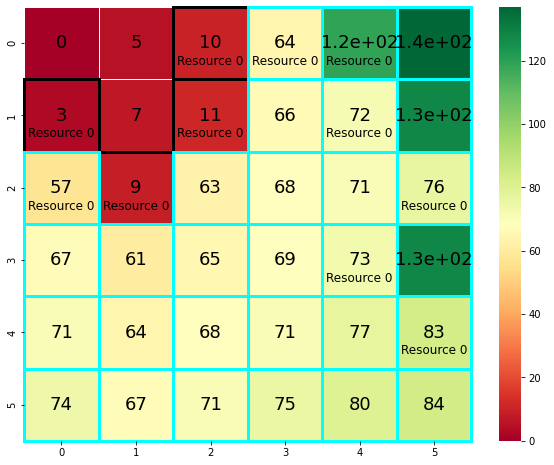

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
sq = int(np.sqrt(n))
tsol = np.reshape(t.x.astype(int), (sq,sq))
node_res = np.argwhere(z.x)
node_protected = np.where(t.X>=g)[0]

fig, (ax1) = plt.subplots(figsize=(sq*1.67,sq*1.33))
sns.heatmap(tsol, linewidth=0.5, annot=True, annot_kws={'size':18, 'color':"black"}, ax=ax1, cmap="RdYlGn")
for i, idx in enumerate(node_res[:,0]):
    row = idx//sq
    col = idx%sq
    ax1.add_patch(plt.Rectangle((col,row), 1, 1, fc='none', ec='black', lw=3, clip_on=False))
    ax1.text(col+0.5,row+0.8,f"Resource {node_res[i,2]}",ha="center", fontsize=12)
    

for idx in node_protected:
    row = idx//sq
    col = idx%sq
    ax1.add_patch(plt.Rectangle((col,row), 1, 1, fc='none', ec='cyan', lw=3, clip_on=False))
    
    

In [12]:
y.x

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.,  0.],
       [ 0.,  0., -0.,  1.,  0.],
       [ 0., -0., -0., -0., -0.],
       [ 0.,  0., -0., -0., -0.],
       [ 0.,  0., -0., -0., -0.],
       [ 0.,  1.,  1.,  1.,  1.],
       [ 0., -0.,  1.,  1.,  0.],
       [ 0.,  0., -0., -0.,  0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.],
       [ 0., -

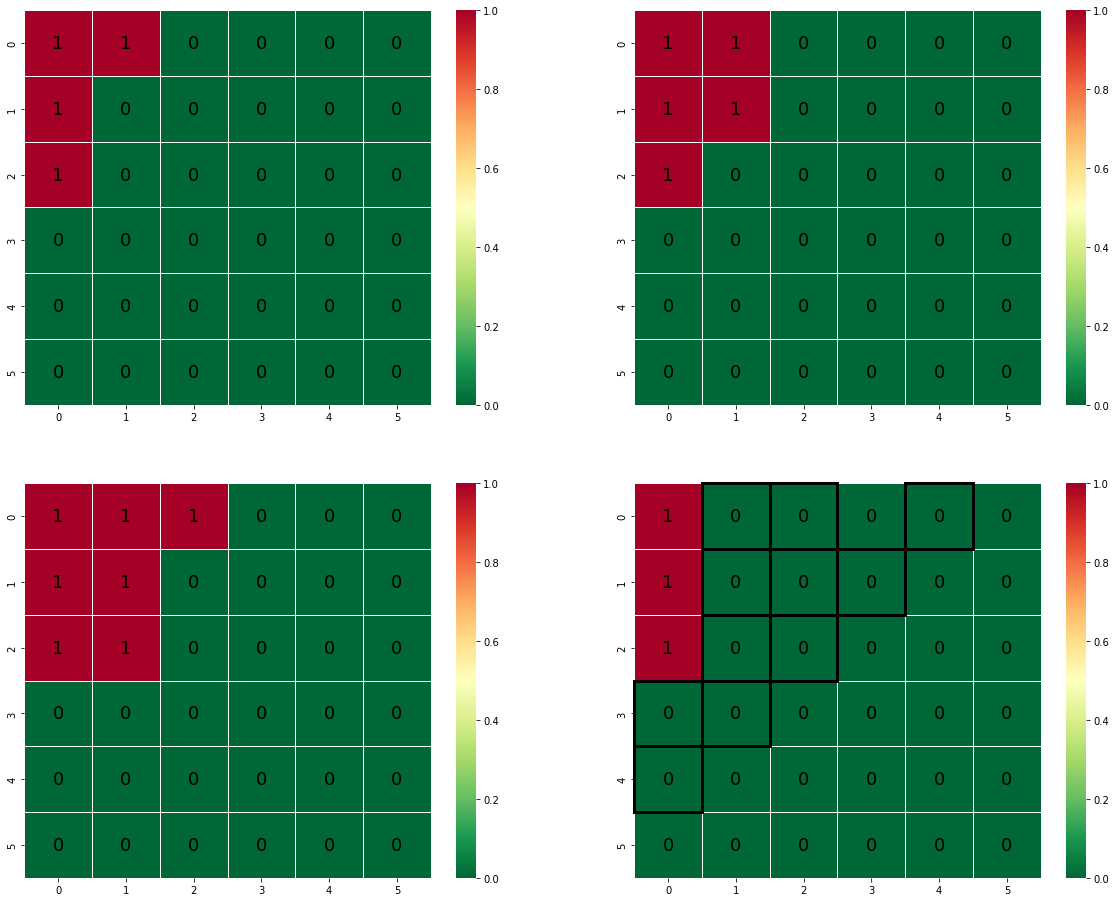

In [144]:
sq = int(np.sqrt(n))
tsol = np.reshape(y.x.astype(int)[:,:len(K)], (sq,sq,len(K)))
node_res = np.argwhere(z.x)


fig, axs = plt.subplots(2,2, figsize=(2*sq*1.67,2*sq*1.33))
sns.heatmap(tsol[:,:,1], linewidth=0.5, annot=True, annot_kws={'size':18, 'color':"black"}, ax=axs[0,0], cmap="RdYlGn_r")
sns.heatmap(tsol[:,:,2], linewidth=0.5, annot=True, annot_kws={'size':18, 'color':"black"}, ax=axs[0,1], cmap="RdYlGn_r")
sns.heatmap(tsol[:,:,3], linewidth=0.5, annot=True, annot_kws={'size':18, 'color':"black"}, ax=axs[1,0], cmap="RdYlGn_r")
sns.heatmap(tsol[:,:,4], linewidth=0.5, annot=True, annot_kws={'size':18, 'color':"black"}, ax=axs[1,1], cmap="RdYlGn_r")

for i, idx in enumerate(node_res[:,0]):
    row = idx//sq
    col = idx%sq
    axs[1,1].add_patch(plt.Rectangle((col,row), 1, 1, fc='none', ec='black', lw=3, clip_on=False))

    
